In [1]:
import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import helper
from helper import subset_aoi
from helper import load_shapefile
from helper import plot_shapefile
import pandas as pd

%matplotlib inline
sns.set()

In [26]:
# Peel back layers of ACS Geodatabase so we can get blocklevel shapefile, and
# separate each table of data contained within.

helper.peel_geodatabase()

Dumping X00_COUNTS to csv
Dumping X01_AGE_AND_SEX to csv
Dumping X02_RACE to csv
Dumping X03_HISPANIC_OR_LATINO_ORIGIN to csv
Dumping X07_MIGRATION to csv
Dumping X08_COMMUTING to csv
Dumping X09_CHILDREN_HOUSEHOLD_RELATIONSHIP to csv
Dumping X11_HOUSEHOLD_FAMILY_SUBFAMILIES to csv
Dumping X12_MARITAL_STATUS_AND_HISTORY to csv
Dumping X14_SCHOOL_ENROLLMENT to csv
Dumping X15_EDUCATIONAL_ATTAINMENT to csv
Dumping X16_LANGUAGE_SPOKEN_AT_HOME to csv
Dumping X17_POVERTY to csv
Dumping X19_INCOME to csv
Dumping X20_EARNINGS to csv
Dumping X21_VETERAN_STATUS to csv
Dumping X22_FOOD_STAMPS to csv
Dumping X23_EMPLOYMENT_STATUS to csv
Dumping X24_INDUSTRY_OCCUPATION to csv
Dumping X25_HOUSING_CHARACTERISTICS to csv
Dumping X27_HEALTH_INSURANCE to csv
Dumping X99_IMPUTATION to csv
Dumping BG_METADATA_2016 to csv
Dumping ACS_2016_5YR_BG_06_CALIFORNIA to shapefile


In [2]:
# Load blockgroup shapefile and trim down to SF areas only (based on countyFP code for SF). Save
# out in ./data/coreshape/ folder

def create_sf_blockgroup():
    blockgroup_path = './data/ACS2016/ACS_2016_5YR_BG_06_CALIFORNIA.shp'
    blockgroup_shape = load_shapefile(blockgroup_path)

    # There's a strange area selected; remove this area
    # Create a temp float column so we can slice out strange area. Can't save back to
    # shapefile if cols of our df is casted as float.
    temp = blockgroup_shape[['INTPTLON', 'COUNTYFP']]
    temp['INTPTLON'] = blockgroup_shape['INTPTLON'].astype(float)

    sf_blockgroup = blockgroup_shape.loc[(temp['COUNTYFP'] == '075') &\
                                         (temp['INTPTLON'] >= -122.55) &\
                                         (temp['INTPTLON'] <= -122.30)]
    sf_blockgroup.to_file('./data/coreshape/sf_blockgroup.shp')

In [3]:
def trim_blockgroup(fp, area_threshold=0.0002):
    '''Some of these blockgroup areas extend beyond the city into the ocean.
    We will clip these out by area_threshold filtering.
    
    Args:
    fp (str): Filepath with name of new shapefile output
    area_threshold (float): Define a threshold value, over which an area is discarded
    
    Return:
    None - Output the filtered geometry back to shapefile
    '''
    sf_blockgroup = load_shapefile('./data/coreshape/sf_blockgroup.shp')
    sf_blockgroup['geometry'] = sf_blockgroup['geometry'].to_crs(epsg=26910)
    sf_blockgroup.crs = {'init' :'epsg:26910'}
    sf_blockgroup = sf_blockgroup[sf_blockgroup['Shape_Area'] < area_threshold]
    sf_blockgroup.to_file(fp)

trim_blockgroup('./data/coreshape/sf_blockgroup_trimmed.shp')

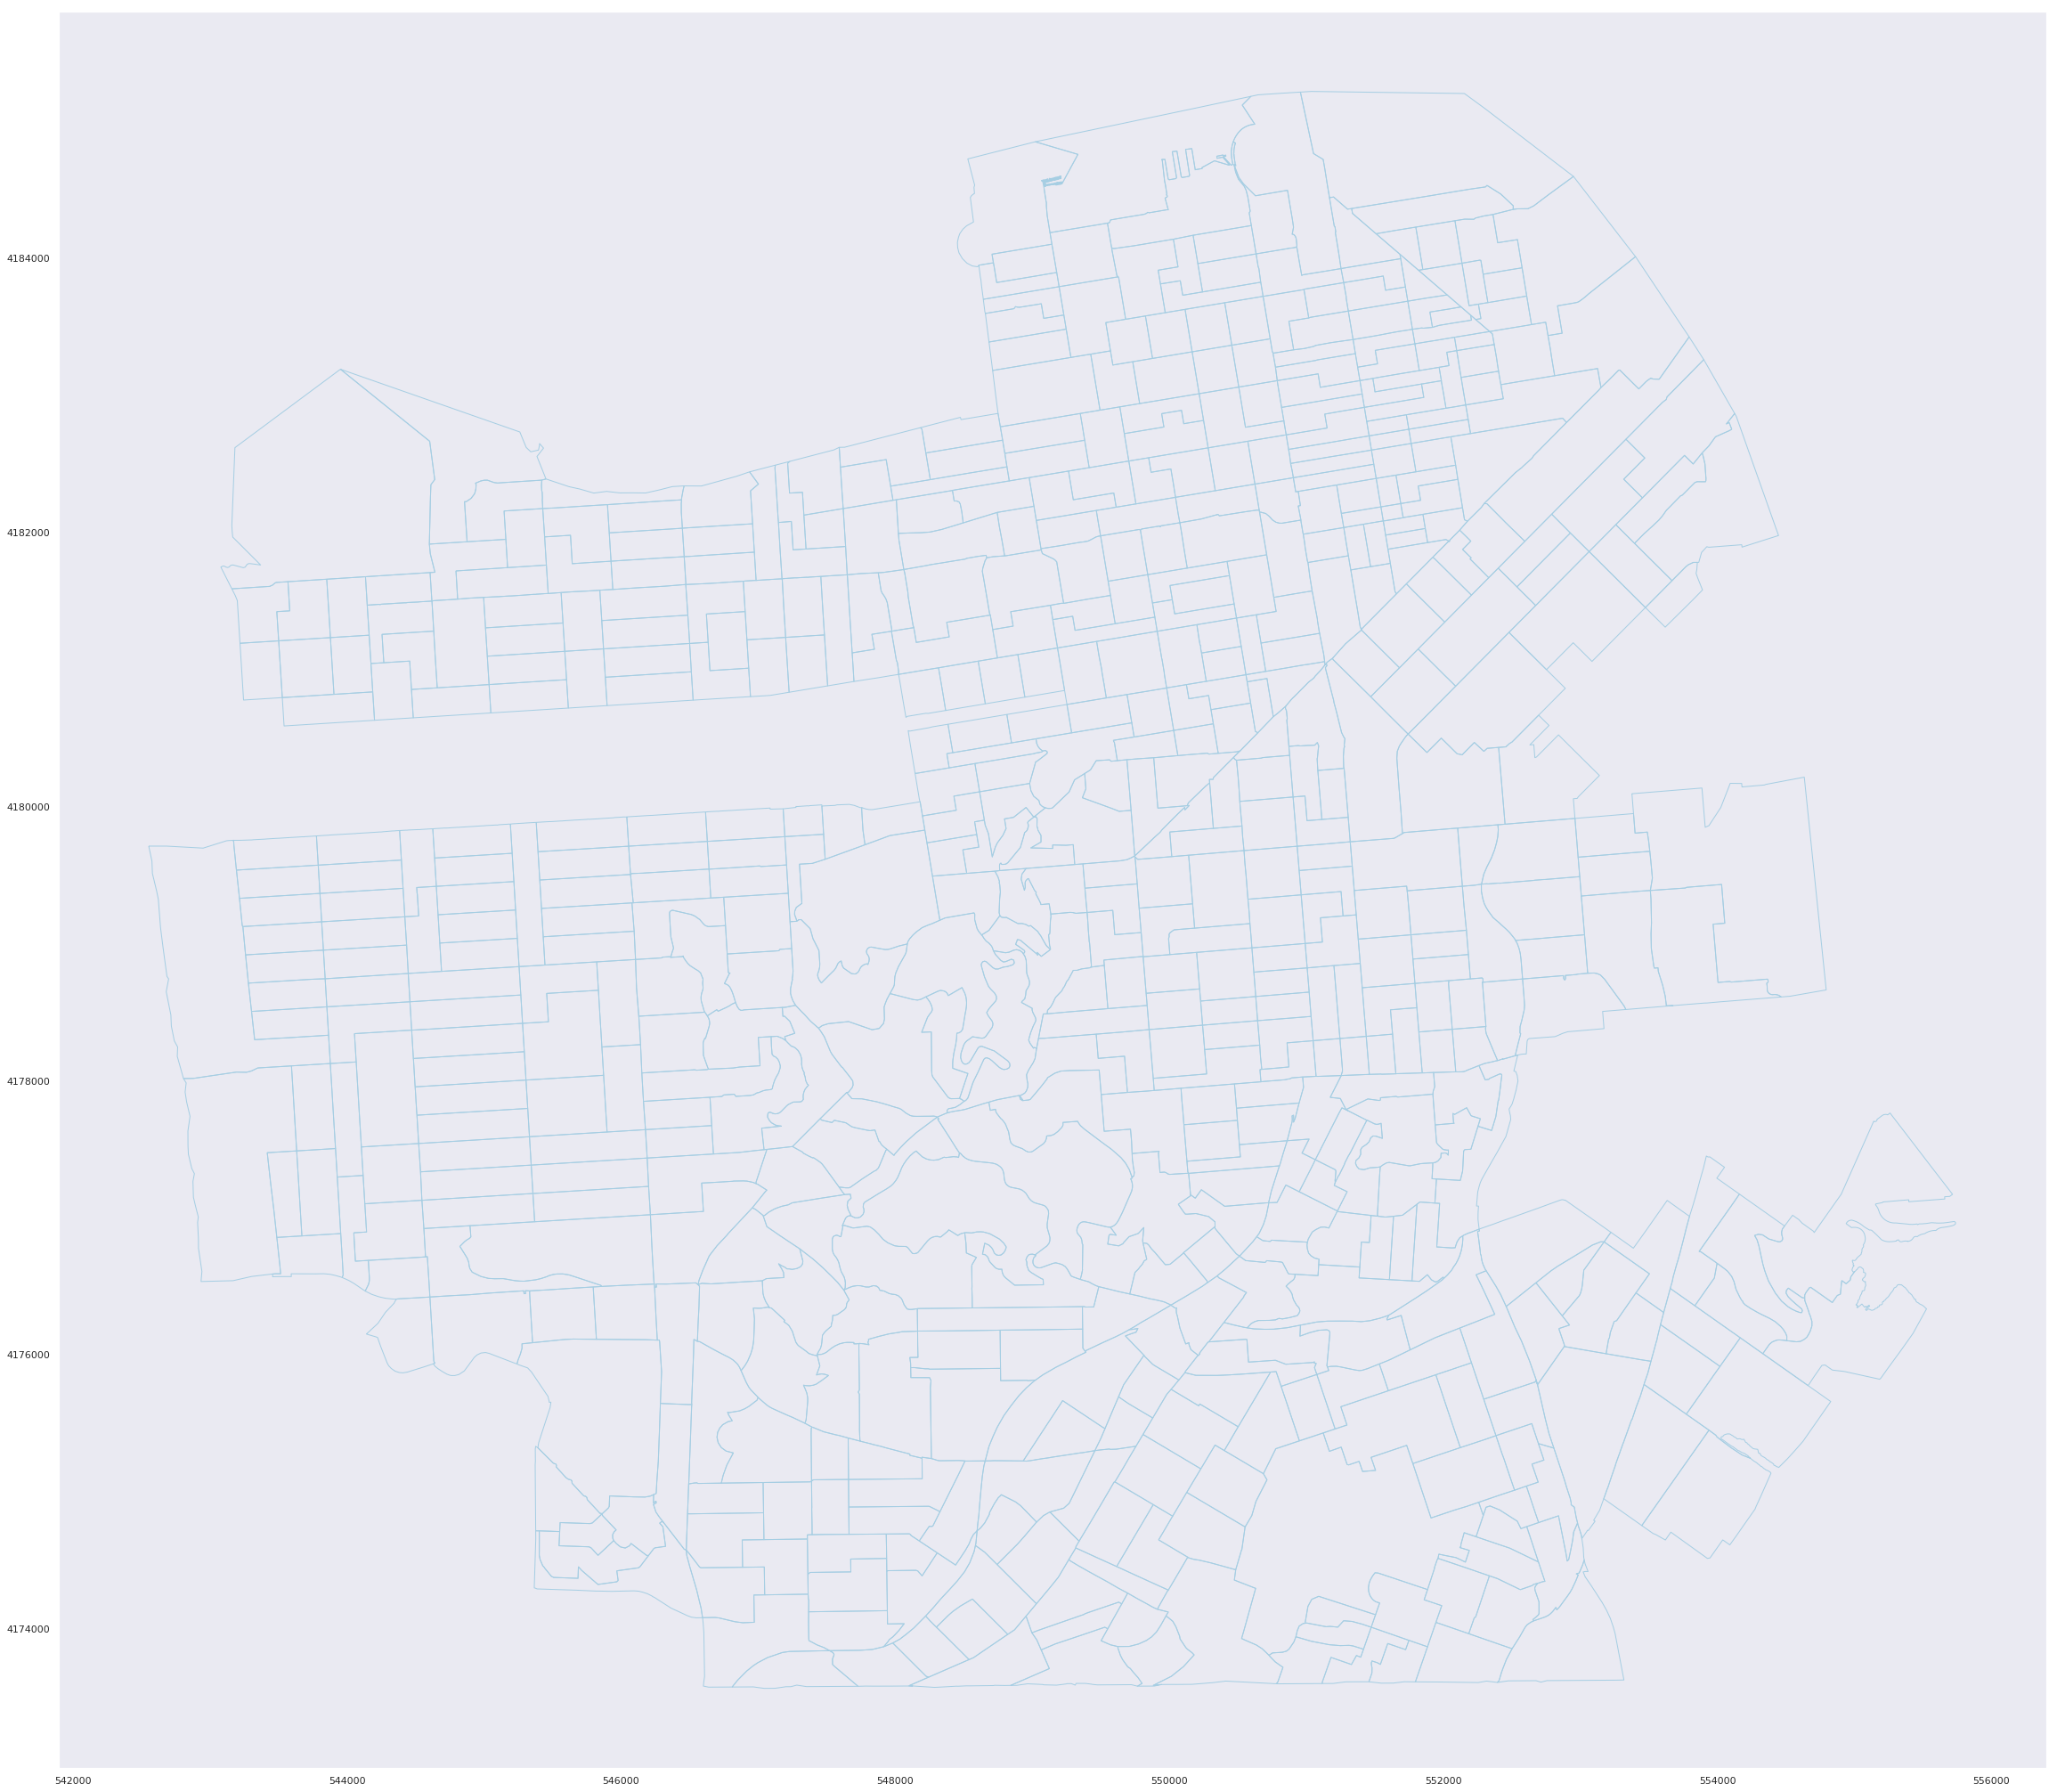

In [4]:
# Test plot our segmented blockgroup here
sf_ZCTA = load_shapefile('./data/coreshape/sf_ZCTA.shp')
sf_blockgroup_fp = './data/coreshape/sf_blockgroup_trimmed.shp'
sf_blockgroup_trimmed = load_shapefile(sf_blockgroup_fp)

settings = {'color': 'none'}
plot_shapefile([sf_blockgroup_trimmed], graph_settings=settings)

In [5]:
poverty_fp = './data/ACS2016/X17_POVERTY.csv'
count_fp = './data/ACS2016/X00_COUNTS.csv'
meta_data = './data/ACS2016/BG_METADATA_2016.csv'
meta= pd.read_csv(meta_data)
count = pd.read_csv(count_fp)

In [6]:
def merge_income_blockgroup_shapefile():
    # Use this module to find cols of interest (from coded column names) within X19_INCOME layer

    # The following are columns of interest
    # Code mapping from X19_INCOME layer:
    # 'B19025e1': AGGREGATE HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate)
    # 'B19301e1': PER CAPITA INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): Total: Total population -- (Estimate)
    # 'B19001e2': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): Less than $10,000: Households -- (Estimate)
    # 'B19001e3': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $10,000 to $14,999: Households -- (Estimate)
    # 'B19001e4': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $15,000 to $19,999: Households -- (Estimate)
    # 'B19001e5': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $20,000 to $24,999: Households -- (Estimate)
    # 'B19001e6': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $25,000 to $29,999: Households -- (Estimate)
    # 'B19001e7': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $30,000 to $34,999: Households -- (Estimate)
    # 'B19001e8': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $35,000 to $39,999: Households -- (Estimate)
    # 'B19001e9': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $40,000 to $44,999: Households -- (Estimate)
    # 'B19001e10': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $45,000 to $49,999: Households -- (Estimate)
    # 'B19001e11': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $50,000 to $59,999: Households -- (Estimate)
    # 'B19001e12': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $60,000 to $74,999: Households -- (Estimate)
    # 'B19001e13': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $75,000 to $99,999: Households -- (Estimate)
    # 'B19001e14': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $100,000 to $124,999: Households -- (Estimate)
    # 'B19001e15': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $125,000 to $149,999: Households -- (Estimate)
    # 'B19001e16': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $150,000 to $199,999: Households -- (Estimate)
    # 'B19001e17': HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $200,000 or more: Households -- (Estimate)

    coded_cols = ['B19013e1', 'B19025e1', 'B19301e1', 'B19001e2', 'B19001e3', 'B19001e4', 'B19001e5',\
                  'B19001e6', 'B19001e7', 'B19001e8', 'B19001e9', 'B19001e10', 'B19001e11',\
                  'B19001e12', 'B19001e13', 'B19001e14', 'B19001e15', 'B19001e16', 'B19001e17', 'GEOID']
    
    # Keep income_cols for reference of cols we need
    income_cols= \
    ['HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): Less than $10,000: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $10,000 to $14,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $15,000 to $19,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $20,000 to $24,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $25,000 to $29,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $30,000 to $34,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $35,000 to $39,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $40,000 to $44,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $45,000 to $49,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $50,000 to $59,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $60,000 to $74,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $75,000 to $99,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $100,000 to $124,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $125,000 to $149,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $150,000 to $199,999: Households -- (Estimate)',
     'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): $200,000 or more: Households -- (Estimate)']
    
#     Rename the income col something human reable for debugging
#     meta_dict = dict(zip(meta['Short_Name'], meta['Full_Name']))
#     income = income.rename(index=str, columns=meta_dict)
    
    # Read in INCOME table from ACS 2016
    income_fp = './data/ACS2016/X19_INCOME.csv'
    income = pd.read_csv(income_fp)

    # Take cols of interest from income sheet and create new sheet
    new_income = income[coded_cols]
    col_code = ['GEOID', 'B19013e1', 'B19025e1', 'B19301e1', 'B19001e2', 'B19001e3', 'B19001e4', 'B19001e5',\
                  'B19001e6', 'B19001e7', 'B19001e8', 'B19001e9', 'B19001e10', 'B19001e11',\
                  'B19001e12', 'B19001e13', 'B19001e14', 'B19001e15', 'B19001e16', 'B19001e17']
    col_name = ['GEOID', 'median_inc','agg_inc', 'per_capita', 'less_10k', '10k_15k', '15k_20k', '20k_25k',
                '25k_30k', '30k_35k', '35k_40k', '40k_45k', '45k_50k', '50k-60k', 
                '60k_75k', '75k_100k', '100k_125k', '125k_150k', '150k_200k', '200k_more'] 
    col_map = dict(zip(col_code, col_name))

    # Calculate the ratio of residents below 25k for each geoID (blockgroup in CA) 
    new_income = new_income.rename(index=str, columns=col_map)
    total_recorded = new_income['less_10k'] +\
                    new_income['10k_15k'] +\
                    new_income['15k_20k'] +\
                    new_income['20k_25k'] +\
                    new_income['25k_30k'] +\
                    new_income['30k_35k'] +\
                    new_income['35k_40k'] +\
                    new_income['40k_45k'] +\
                    new_income['45k_50k'] +\
                    new_income['50k-60k'] +\
                    new_income['60k_75k'] +\
                    new_income['75k_100k'] +\
                    new_income['100k_125k'] +\
                    new_income['125k_150k'] +\
                    new_income['150k_200k'] +\
                    new_income['200k_more']

    below_25k = new_income['less_10k'] +\
                    new_income['10k_15k'] +\
                    new_income['15k_20k'] +\
                    new_income['20k_25k']

    below_25k_ratio = below_25k/total_recorded
    new_income['25k_ratio'] = below_25k_ratio
    new_income = new_income.loc[below_25k_ratio.notnull()]
    # Slice the GEOID to match with provided GEOID in blocklevel shapefile
    new_income['GEOID']= new_income['GEOID'].apply(lambda x: x[7:])

    # Join this income data with our blockgroup shapefile and save to file
    sf_blockgroup_data = sf_blockgroup_trimmed.merge(new_income, on='GEOID')
    sf_blockgroup_data.to_file('./data/blockgroup_income_merged.shp')

merge_income_blockgroup_shapefile()

In [7]:
income_fp = './data/ACS2016/X19_INCOME.csv'
income = pd.read_csv(income_fp)
meta_dict = dict(zip(meta['Short_Name'], meta['Full_Name']))
income = income.rename(index=str, columns=meta_dict)
for k, v  in meta_dict.items():
    if 'MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate)' in v:
        print(k,v)

B19013e1 MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate)


Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'Shape_Leng', 'Shape_Area', 'GEOID_Data', 'median_inc', 'agg_inc',
       'per_capita', 'less_10k', '10k_15k', '15k_20k', '20k_25k', '25k_30k',
       '30k_35k', '35k_40k', '40k_45k', '45k_50k', '50k-60k', '60k_75k',
       '75k_100k', '100k_125k', '125k_150k', '150k_200k', '200k_more',
       '25k_ratio', 'geometry'],
      dtype='object')


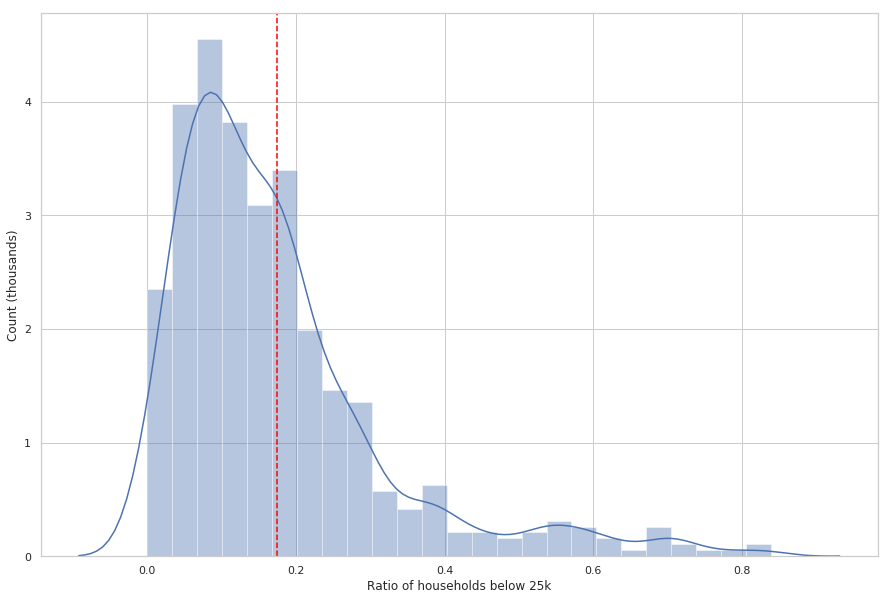

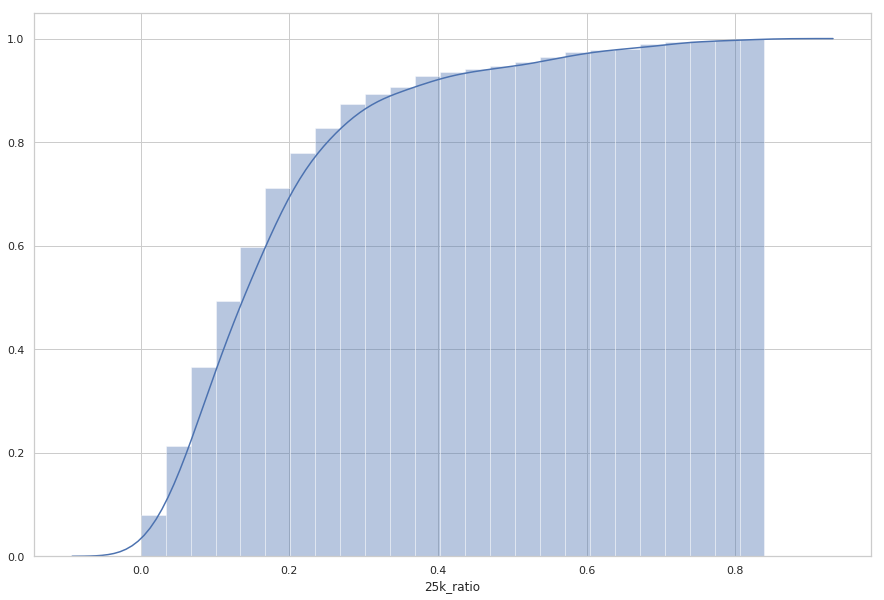

In [14]:
merged_income_block = load_shapefile('./data/blockgroup_income_merged.shp')
print(merged_income_block.columns)

# Plot average ratio
f, ax = plt.subplots(figsize = (15, 10))
sns.distplot(merged_income_block['25k_ratio'], ax=ax)
ax.set(xlabel='Ratio of households below 25k', ylabel='Count (thousands)')
plt.axvline(.174, color='red', linestyle='--')
f.savefig('poverty_ratio.png', format='png')

# Plot cumulative distribution
f2, ax2 = plt.subplots(figsize=(15,10))
sns.distplot(merged_income_block['25k_ratio'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True), ax=ax2)

<Figure size 432x288 with 0 Axes>

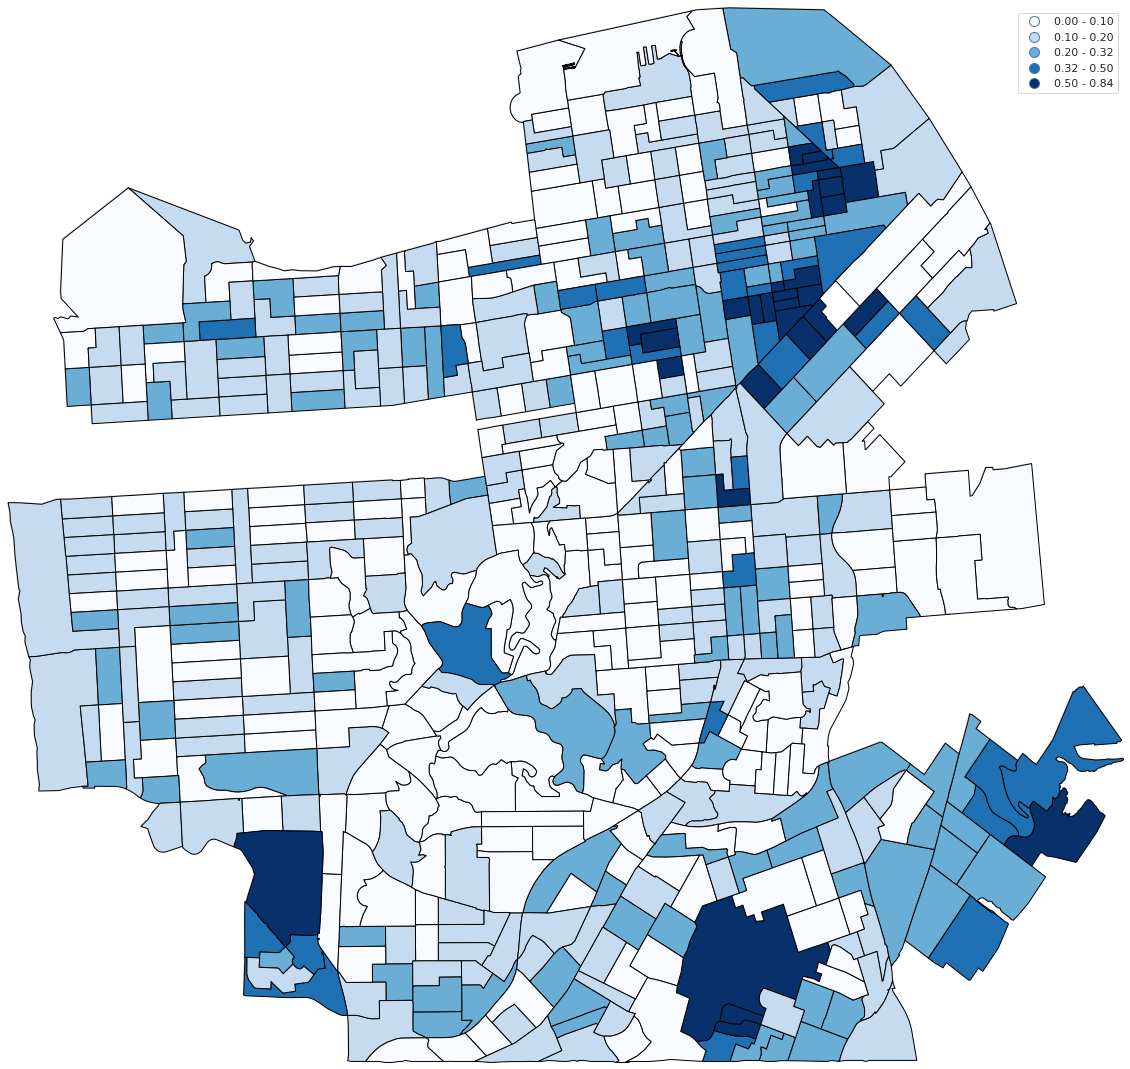

In [15]:
import geoplot as gplt
import geoplot.crs as gcrs
import seaborn as sns

# Convert crs so geoplot knows how to plot
merged_income_block['geometry'] = merged_income_block['geometry'].to_crs({'init': 'epsg:4269'})
merged_income_block.crs = {'init': 'epsg:4269'}

def trivial_scale(minval, maxval): return lambda v: 1
fig = plt.figure()
ax = gplt.cartogram(merged_income_block, projection=gcrs.AlbersEqualArea(), k=5,
               cmap='Blues', scale='25k_ratio', scale_func=trivial_scale, scheme='fisher_Jenks',
               hue='25k_ratio', legend=True, legend_var='hue', figsize=(20, 20), edgecolor='black');